# MACHINE LEARNING MODEL FOR WASTE CLASSIFICATION

## Dataset

Potential dataset sources:

**1. RealWaste Image Classification**

source: https://www.kaggle.com/datasets/joebeachcapital/realwaste/data
+ 9 classes

**2. Taco Trash Dataset**

source: https://www.kaggle.com/datasets/kneroma/tacotrashdataset && http://tacodataset.org/
- 60 categories with 28 super categories (http://tacodataset.org/taxonomy)

<!-- solution in mind:
1. using pre-trained model from TACO dataset to our RealWaste dataset so that we will be able to classify it into classes that we want with a lot more data.
OR
2. using only TACO dataset but we have to search more waste infos. OR
3. using RealWaste dataset only -->

additional links:

<!-- - pretrained model on TACO: https://www.kaggle.com/datasets/bouweceunen/trained-models-taco-trash-annotations-in-context/ -->
- TACO paper: https://arxiv.org/pdf/2003.06975

# **Other Reference**
github recyclo https://github.com/ReCyclo-Bangkit-2023

## **Import libraries**


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
import os
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#import kaggle dataset
!pip install kaggle

# from google.colab import files
# files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d joebeachcapital/realwaste


rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 647M/657M [00:07<00:00, 113MB/s]
100% 657M/657M [00:07<00:00, 94.0MB/s]


In [ ]:
# !kaggle datasets download -d joebeachcapital/realwaste

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('realwaste.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

<hr>
<hr>
<hr>

In [ ]:
# Define the path where our dataset is stored
dataset_path = "/content/realwaste-main/RealWaste"

training_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # splitting the dataset, so now we have data for validation
)

train_generator = training_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    subset='training' # set these generated images as the training data
)

val_generator = training_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    subset='validation' # set these generated images as the validation data
)

Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet'
)
base_model.trainable = False

In [ ]:
inputs = base_model.input
# x = resize_and_rescale(inputs)
# x = data_augmentation(x)

x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples//val_generator.batch_size,
    epochs=100
)

Epoch 1/100
118/118 [==============================] - 49s 377ms/step - loss: 2.1576 - accuracy: 0.1819 - val_loss: 2.1128 - val_accuracy: 0.1940
Epoch 2/100
118/118 [==============================] - 43s 363ms/step - loss: 2.0930 - accuracy: 0.2111 - val_loss: 1.9838 - val_accuracy: 0.2716
Epoch 3/100
118/118 [==============================] - 41s 351ms/step - loss: 2.0160 - accuracy: 0.2458 - val_loss: 1.9590 - val_accuracy: 0.2241
Epoch 4/100
118/118 [==============================] - 43s 364ms/step - loss: 1.9847 - accuracy: 0.2315 - val_loss: 1.9493 - val_accuracy: 0.2414
Epoch 5/100
118/118 [==============================] - 40s 336ms/step - loss: 1.9807 - accuracy: 0.2546 - val_loss: 1.9540 - val_accuracy: 0.2834
Epoch 6/100
118/118 [==============================] - 42s 353ms/step - loss: 1.9688 - accuracy: 0.2593 - val_loss: 1.9580 - val_accuracy: 0.2360
Epoch 7/100
118/118 [==============================] - 43s 366ms/step - loss: 1.9511 - accuracy: 0.2570 - val_loss: 1.9578 -

<hr>
<hr>
<hr>

In [ ]:
# Define the path where our dataset is stored
dataset_path = "/content/realwaste-main/RealWaste"

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

Glass folder contains 420 images.
Textile Trash folder contains 318 images.
Plastic folder contains 921 images.
Cardboard folder contains 461 images.
Food Organics folder contains 411 images.
Miscellaneous Trash folder contains 495 images.
Vegetation folder contains 436 images.
Paper folder contains 500 images.
Metal folder contains 790 images.

All images in the dataset have the same dimensions: 524x524 with 3 color channels.


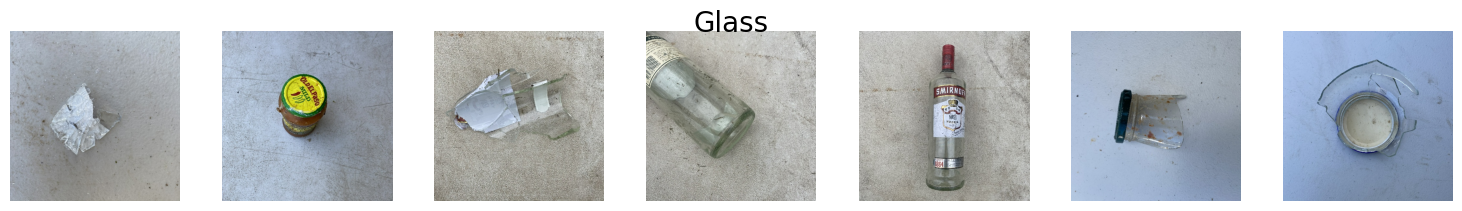

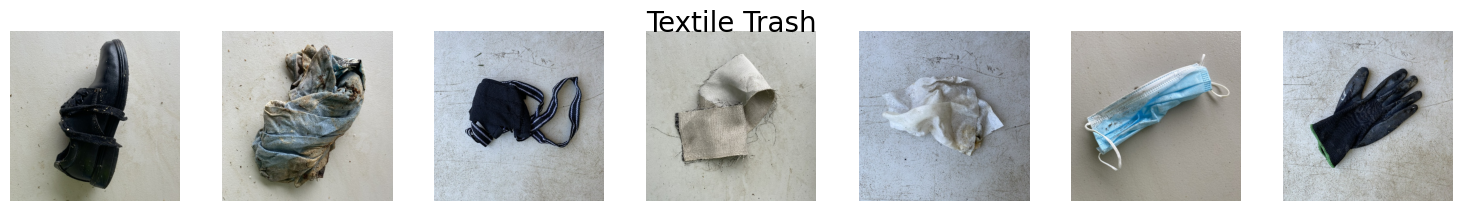

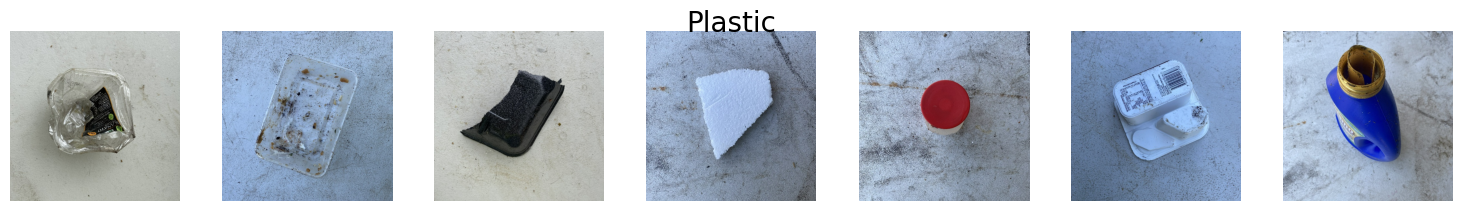

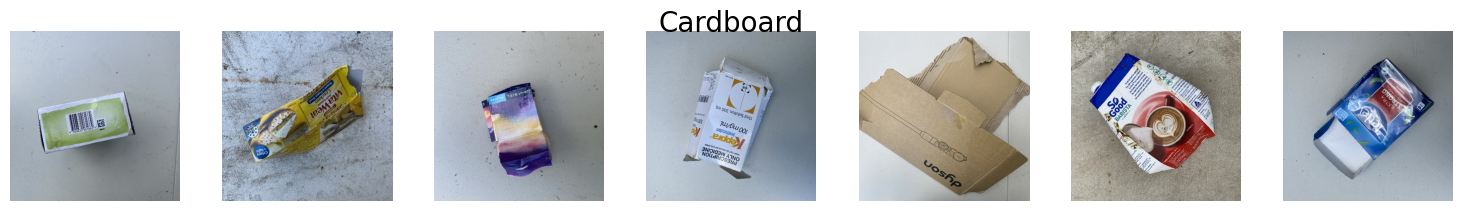

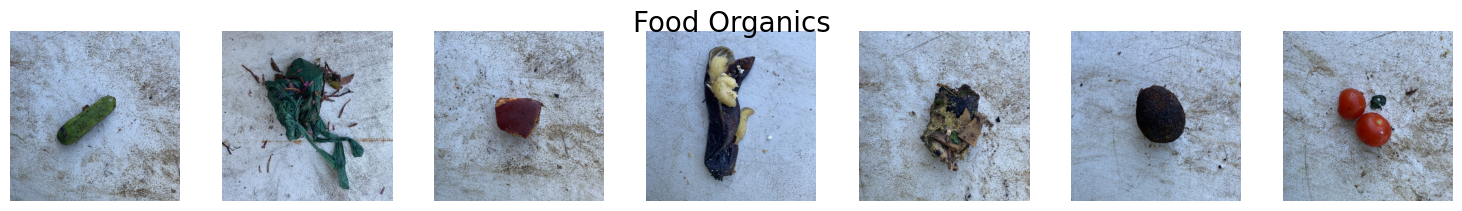

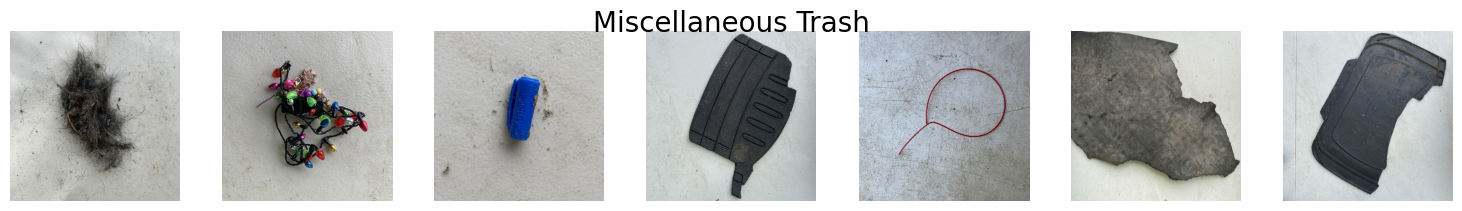

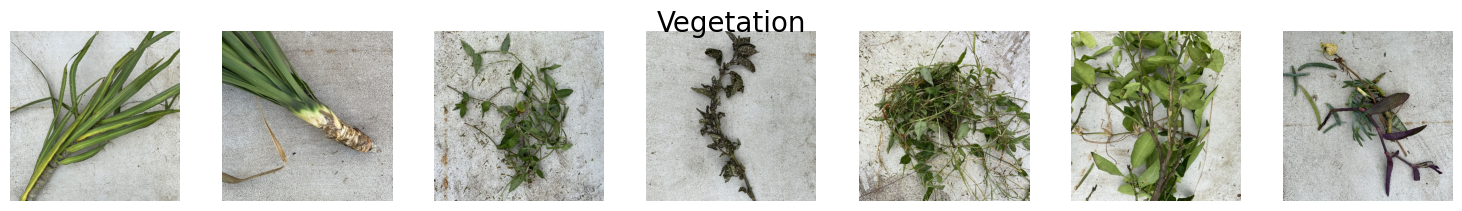

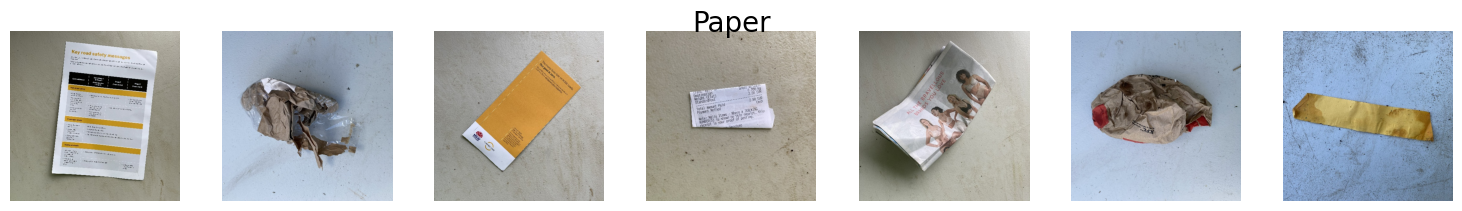

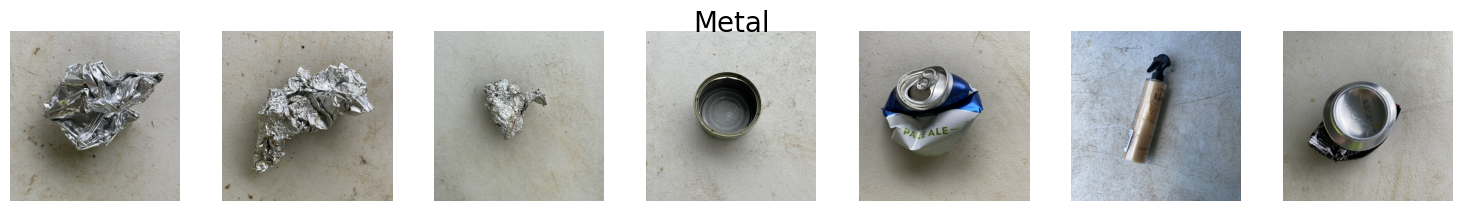

In [ ]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [ ]:
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath  label
0  /content/realwaste-main/RealWaste/Glass/Glass_...  Glass
1  /content/realwaste-main/RealWaste/Glass/Glass_...  Glass
2  /content/realwaste-main/RealWaste/Glass/Glass_...  Glass
3  /content/realwaste-main/RealWaste/Glass/Glass_...  Glass
4  /content/realwaste-main/RealWaste/Glass/Glass_...  Glass

we split the data to 80% - 20%

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 3801
Number of images in the validation set: 951


In [ ]:
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
Plastic                19.38
Metal                  16.62
Paper                  10.52
Miscellaneous Trash    10.42
Cardboard               9.70
Vegetation              9.18
Glass                   8.84
Food Organics           8.65
Textile Trash           6.69
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
Plastic                19.36
Metal                  16.63
Paper                  10.52
Miscellaneous Trash    10.42
Cardboard               9.71
Vegetation              9.18
Glass                   8.84
Food Organics           8.66
Textile Trash           6.68
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
Plastic                19.45
Metal                  16.61
Paper                  10.52
Miscellaneous Trash    10.41
Cardboard               9.67
Vegetation              9.15
Glass    

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
    # val_df,
    # target_size=(224, 224),
    # batch_size=32,
    # class_mode='categorical'
)

Found 3801 validated image filenames belonging to 9 classes.
Found 951 validated image filenames belonging to 9 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name="data_augmentation")

**addressing imbalance dataset**

In [ ]:
# class_labels = train_df['label'].unique()
# class_labels

In [ ]:
# train_generator.class_indices
# weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
# weights

In [ ]:
# class_weights = dict(zip(train_generator.class_indices.values(), weights))
# class_weights

**Load mobilenetv3 model**

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet'
)
base_model.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size,
    epochs=100,
    # callbacks=[
    #     early_stopping,
    #     create_tensorboard_callback("training_logs",
    #                                 "insect_classification"),
    #     checkpoint_callback,
    # ]
)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-35-a0f2b6e4e515>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,9] and labels shape [288]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_19964]

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()